In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings("ignore")

# Red Wine Quality

## Exploratory Data Analysis (EDA)

In [ ]:
df = pd.read_csv("/winequality-red.csv")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


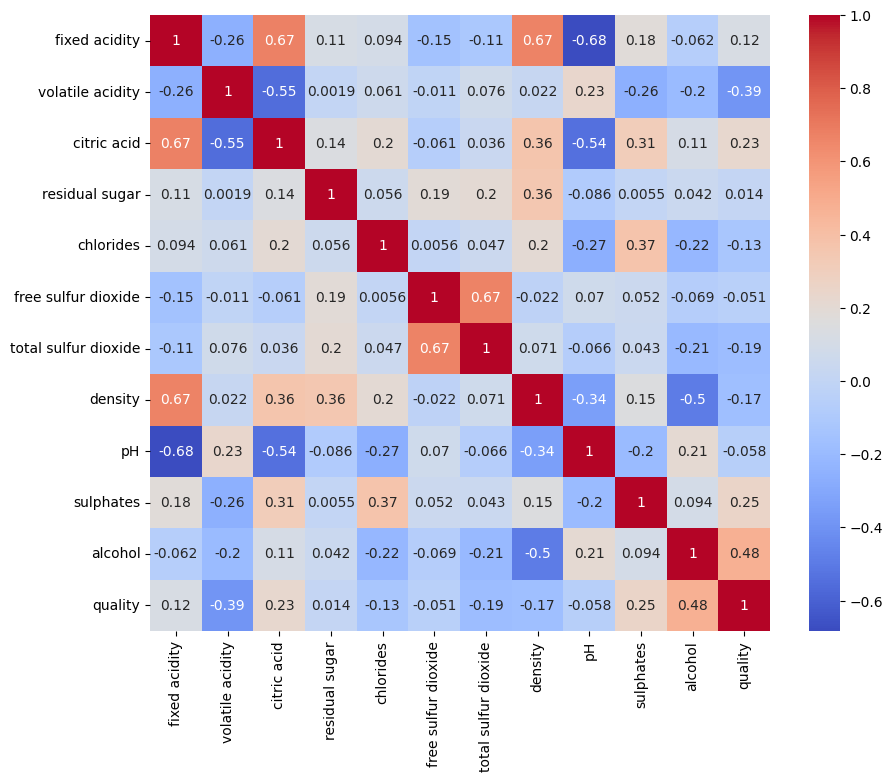

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

### Data Preparation

In [ ]:
# Remove the 2 features with the lowest correlation with the label
df = df.drop(['residual sugar', 'free sulfur dioxide'], axis=1)

# Change the labels to binary values where quality >= 6 is GOOD WINE (1) and below is BAD WINE (0)
df["quality"] = (df["quality"] >= 6).astype(int)

In [ ]:
# Split data into features (X) and label (y)
X = df.drop("quality", axis=1)
y = df.quality

# Split data into training and test sets
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=23)
data_split = list(rskf.split(X, y))

y.value_counts()

,count
quality,
1,855
0,744


## Model Selection

### Logistic Regression

In [ ]:
log_reg_grid = {
    'C': [0.01, 0.1, 1, 10, 100],                           # Regularization parameter
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],  # Algorithm used for optimization
    'max_iter': [200, 500, 1000]                            # Maximum number of iterations allowed for the solver to converge
}

gs_log_reg = GridSearchCV(LogisticRegression(), log_reg_grid)

### Decision Trees

In [ ]:
decision_tree_grid = {
    'max_depth': [None, 3, 5, 7, 10],         # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 15, 20],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 5, 10, 15, 20]    # Minimum number of samples required at a leaf node
}

gs_decision_tree = GridSearchCV(DecisionTreeClassifier(), decision_tree_grid)

### kNN

In [ ]:
knn_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],                  # Number of neighbors
    'weights': ['uniform', 'distance'],               # Weight function to apply to neighbors
    'metric': ['euclidean', 'manhattan', 'minkowski'] # Distance metric to use
}

gs_knn = GridSearchCV(KNeighborsClassifier(), knn_grid)

### Neural Networks

In [ ]:
neural_network_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Hidden layers size
    'activation': ['logistic', 'relu'],               # Activation functions
    'solver': ['adam', 'sgd'],                        # Optimization algorithms
}

gs_neural_network = GridSearchCV(MLPClassifier(), neural_network_grid)

## Model Training

In [ ]:
wine_accuracy = {}
wine_precision = {}
wine_recall = {}
wine_auc = {}
wine_fpr_tpr = {}

def train_models(models, data_split):
    global wine_accuracy, wine_precision, wine_recall, wine_auc, wine_fpr_tpr

    for name, model in models.items():
        print(f"Training {name}...")
        start_time = time.time()

        train_accuracy = []
        wine_accuracy[name] = []
        wine_precision[name] = []
        wine_recall[name] = []
        wine_auc[name] = []
        wine_fpr_tpr[name] = [(np.linspace(0, 1, 100))]  # Common values for interpolation
        wine_fpr_tpr[name].append(np.zeros_like(wine_fpr_tpr[name][0]))  # Initialize average TPR with zeros

        for train_index, test_index in data_split:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.loc[train_index], y.iloc[test_index]

            model.fit(X_train, y_train)

            train_accuracy.append(model.score(X_train, y_train))

            # Predict on the test set
            y_pred = model.predict(X_test)

            # Predicted probabilities for the positive class
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc = roc_auc_score(y_test, y_pred_proba)

            # Calculate and store metrics
            wine_accuracy[name].append(model.score(X_test, y_test))
            wine_precision[name].append(precision_score(y_test, y_pred))
            wine_recall[name].append(recall_score(y_test, y_pred))
            wine_auc[name].append(auc)
            wine_fpr_tpr[name][1] += np.interp(wine_fpr_tpr[name][0], fpr, tpr)  # Interpolate and accumulate TPR

        wine_fpr_tpr[name][1] /= len(data_split)

        end_time = time.time()
        average_accuracy = np.mean(train_accuracy)
        print(f"Training accuracy: {average_accuracy:.2f}")
        print(f"Training time: {end_time - start_time:.2f} seconds")

    wine_accuracy = {model: np.mean(scores) for model, scores in wine_accuracy.items()}
    wine_precision = {model: np.mean(scores) for model, scores in wine_precision.items()}
    wine_recall = {model: np.mean(scores) for model, scores in wine_recall.items()}
    wine_auc = {model: np.mean(scores) for model, scores in wine_auc.items()}

In [ ]:
models = {
    "Logistic Regression": gs_log_reg,
    "Decision Tree": gs_decision_tree,
    "kNN": gs_knn,
    "Neural Network": gs_neural_network
}

train_models(models, data_split)

Training Logistic Regression...
Training accuracy: 0.75
Training time: 98.41 seconds
Training Decision Tree...
Training accuracy: 0.77
Training time: 29.96 seconds
Training kNN...
Training accuracy: 0.95
Training time: 12.24 seconds
Training Neural Network...
Training accuracy: 0.74
Training time: 294.91 seconds


## Results

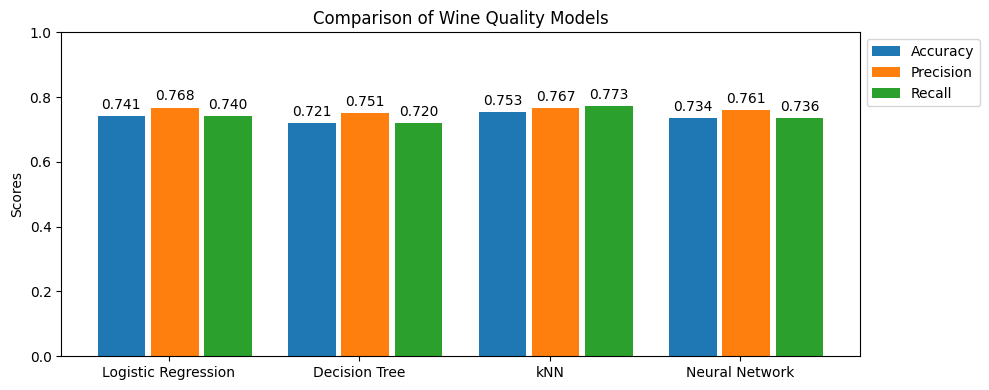

In [ ]:
model_names = list(models.keys())

# Extracting values from dictionaries
accuracy_values = [wine_accuracy[model] for model in model_names]
precision_values = [wine_precision[model] for model in model_names]
recall_values = [wine_recall[model] for model in model_names]

# Set positions and width for bars
x = np.arange(len(model_names))  # the label locations
width = 0.25  # the width of the bars

# Create the bar plots
fig, ax = plt.subplots(figsize=(10, 4))
accuracy_bars = ax.bar(x - width, accuracy_values, width, label='Accuracy')
precision_bars = ax.bar(x + 0.03, precision_values, width, label='Precision')
recall_bars = ax.bar(x + width + 0.06, recall_values, width, label='Recall')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparison of Wine Quality Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylim(0, 1)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add value labels on top of bars
def add_value_labels(bars):
    # Add value labels on top of bars in the chart.
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(accuracy_bars)
add_value_labels(precision_bars)
add_value_labels(recall_bars)

# Show the plot
plt.tight_layout()
plt.show()

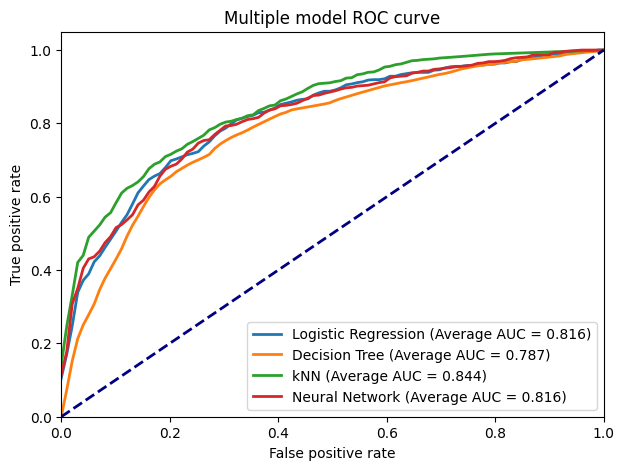

In [ ]:
# Create graphic
plt.figure(figsize=(7, 5))

# A curve for each model
for model in model_names:
    plt.plot(wine_fpr_tpr[model][0], wine_fpr_tpr[model][1], label=f'{model} (Average AUC = {wine_auc[model]:.3f})', lw=2)

# Add labels
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Multiple model ROC curve')
plt.legend(loc="lower right")
plt.show()


# Water Quality

## Exploratory Data Analysis (EDA)

In [ ]:
df = pd.read_csv("/water_potability.csv")
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [ ]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


array([[<Axes: title={'center': 'ph'}>,
        <Axes: title={'center': 'Hardness'}>,
        <Axes: title={'center': 'Solids'}>],
       [<Axes: title={'center': 'Chloramines'}>,
        <Axes: title={'center': 'Sulfate'}>,
        <Axes: title={'center': 'Conductivity'}>],
       [<Axes: title={'center': 'Organic_carbon'}>,
        <Axes: title={'center': 'Trihalomethanes'}>,
        <Axes: title={'center': 'Turbidity'}>]], dtype=object)

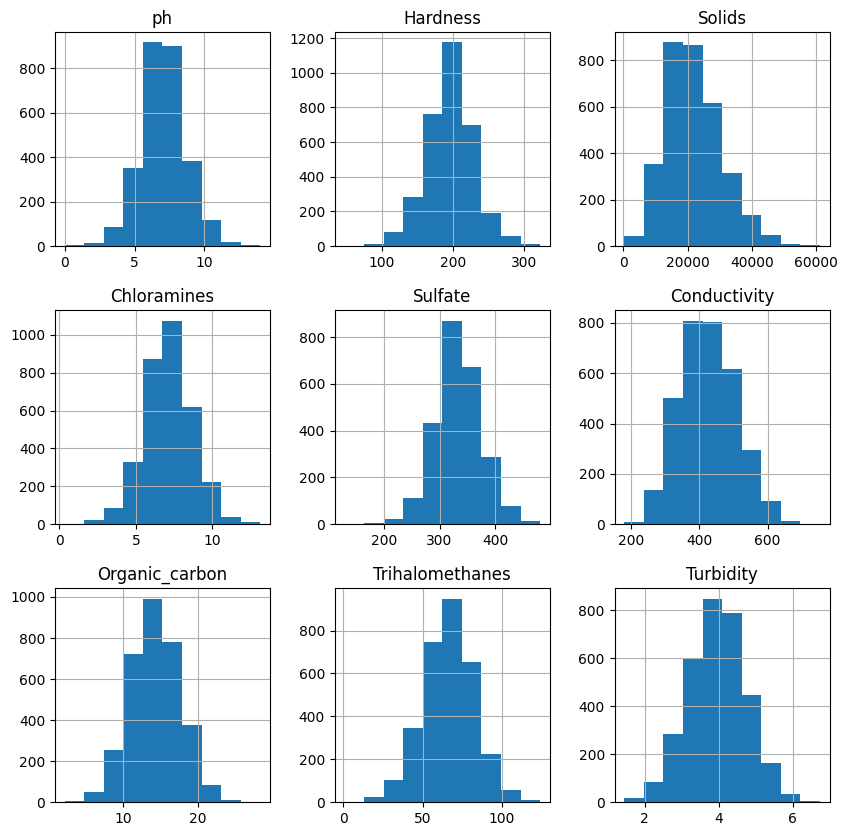

In [ ]:
df.drop('Potability', axis = 1).hist(figsize = (10,10))

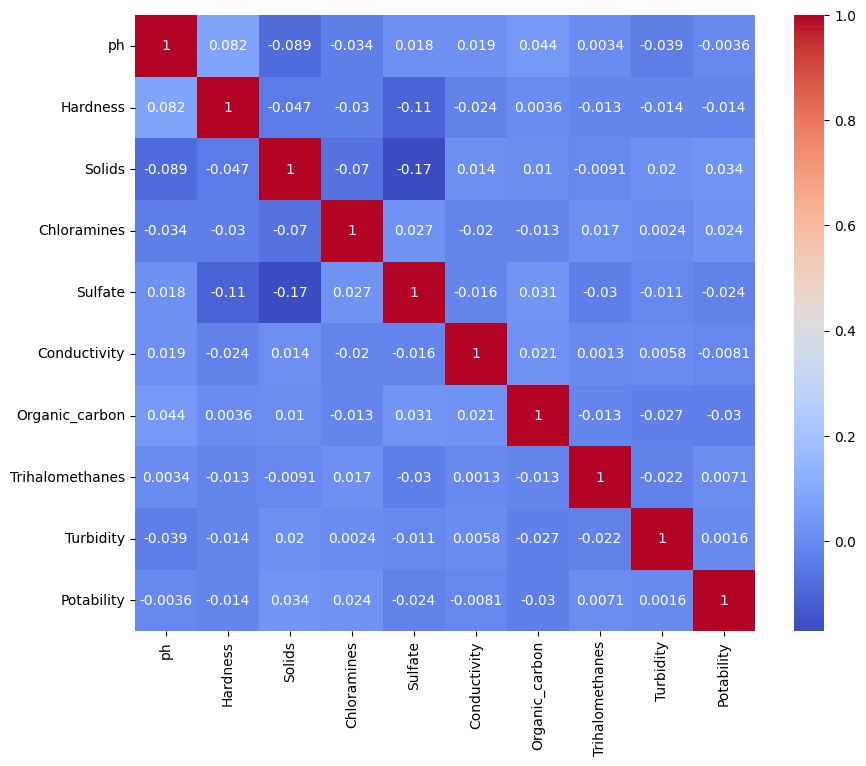

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

## Data Preparation

In [ ]:
# Verify null data
df.isnull().sum()

,0
ph,491
Hardness,0
Solids,0
Chloramines,0
Sulfate,781
Conductivity,0
Organic_carbon,0
Trihalomethanes,162
Turbidity,0
Potability,0


In [ ]:
df.isnull().mean() * 100

,0
ph,14.987790
Hardness,0.000000
Solids,0.000000
Chloramines,0.000000
Sulfate,23.840049
Conductivity,0.000000
Organic_carbon,0.000000
Trihalomethanes,4.945055
Turbidity,0.000000
Potability,0.000000


In [ ]:
# Change null values with feature median
df['ph'] = df['ph'].fillna(value=df['ph'].median())
df['Sulfate'] = df['Sulfate'].fillna(value=df['Sulfate'].median())
df['Trihalomethanes'] = df['Trihalomethanes'].fillna(value=df['Trihalomethanes'].median())
df.isnull().sum()


,0
ph,0
Hardness,0
Solids,0
Chloramines,0
Sulfate,0
Conductivity,0
Organic_carbon,0
Trihalomethanes,0
Turbidity,0
Potability,0


In [ ]:
# Split data into features and labels
x = df.drop('Potability', axis = 1)
y = df['Potability']

y.value_counts()

,count
Potability,
0,1998
1,1278


In [ ]:
# Balance data
smote = SMOTE(random_state=23)
x_resampled, y_resampled = smote.fit_resample(x, y)


# Split data into training and testing
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=23)
data_split = list(rskf.split(x_resampled, y_resampled))
y_resampled.value_counts()

,count
Potability,
0,1998
1,1998


## Model Training

In [ ]:
water_accuracy = {}
water_precision = {}
water_recall = {}
water_auc = {}
water_fpr_tpr = {}

def train_models(models, data_split):
    global water_accuracy, water_precision, water_recall, water_auc, water_fpr_tpr

    for name, model in models.items():
        print(f"Training {name}...")
        start_time = time.time()

        train_accuracy = []
        water_accuracy[name] = []
        water_precision[name] = []
        water_recall[name] = []
        water_auc[name] = []
        water_fpr_tpr[name] = [(np.linspace(0, 1, 100))]  # Common values for interpolation
        water_fpr_tpr[name].append(np.zeros_like(water_fpr_tpr[name][0]))  # Initialize average TPR with zeros

        for train_index, test_index in data_split:
            X_train, X_test = x_resampled.iloc[train_index], x_resampled.iloc[test_index]
            y_train, y_test = y_resampled.loc[train_index], y_resampled.iloc[test_index]

            # Normalize data
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            model.fit(X_train, y_train)

            train_accuracy.append(model.score(X_train, y_train))

            # Predict on the test set
            y_pred = model.predict(X_test)

            # Predicted probabilities for the positive class
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc = roc_auc_score(y_test, y_pred_proba)

            # Calculate and store metrics
            water_accuracy[name].append(model.score(X_test, y_test))
            water_precision[name].append(precision_score(y_test, y_pred))
            water_recall[name].append(recall_score(y_test, y_pred))
            water_auc[name].append(auc)
            water_fpr_tpr[name][1] += np.interp(water_fpr_tpr[name][0], fpr, tpr)  # Interpolate and accumulate TPR

        water_fpr_tpr[name][1] /= len(data_split)

        end_time = time.time()
        average_accuracy = np.mean(train_accuracy)
        print(f"Training accuracy: {average_accuracy:.2f}")
        print(f"Training time: {end_time - start_time:.2f} seconds")

    water_accuracy = {model: np.mean(scores) for model, scores in water_accuracy.items()}
    water_precision = {model: np.mean(scores) for model, scores in water_precision.items()}
    water_recall = {model: np.mean(scores) for model, scores in water_recall.items()}
    water_auc = {model: np.mean(scores) for model, scores in water_auc.items()}

In [ ]:
# Define model dictionary
models = {
    "Logistic Regression": gs_log_reg,
    "Decision Tree": gs_decision_tree,
    "kNN": gs_knn,
    "Neural Network": gs_neural_network
}

train_models(models, data_split)

Training Logistic Regression...
Training accuracy: 0.52
Training time: 21.49 seconds
Training Decision Tree...
Training accuracy: 0.94
Training time: 84.38 seconds
Training kNN...
Training accuracy: 1.00
Training time: 47.52 seconds
Training Neural Network...
Training accuracy: 0.86
Training time: 523.34 seconds


## Results

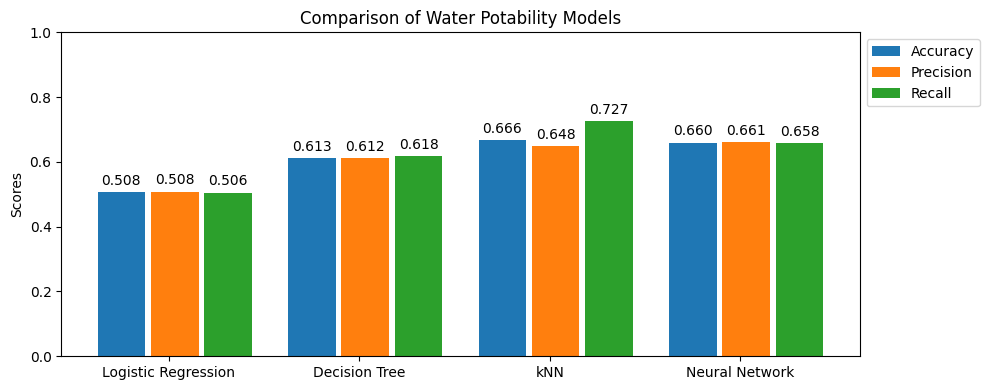

In [ ]:
model_names = list(models.keys())

# Extracting values from dictionaries
accuracy_values = [water_accuracy[model] for model in model_names]
precision_values = [water_precision[model] for model in model_names]
recall_values = [water_recall[model] for model in model_names]

# Set positions and width for bars
x = np.arange(len(model_names))  # the label locations
width = 0.25  # the width of the bars

# Create the bar plots
fig, ax = plt.subplots(figsize=(10, 4))
accuracy_bars = ax.bar(x - width, accuracy_values, width, label='Accuracy')
precision_bars = ax.bar(x + 0.03, precision_values, width, label='Precision')
recall_bars = ax.bar(x + width + 0.06, recall_values, width, label='Recall')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparison of Water Potability Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylim(0, 1)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add value labels on top of bars
def add_value_labels(bars):
    # Add value labels on top of bars in the chart.
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(accuracy_bars)
add_value_labels(precision_bars)
add_value_labels(recall_bars)

# Show the plot
plt.tight_layout()
plt.show()



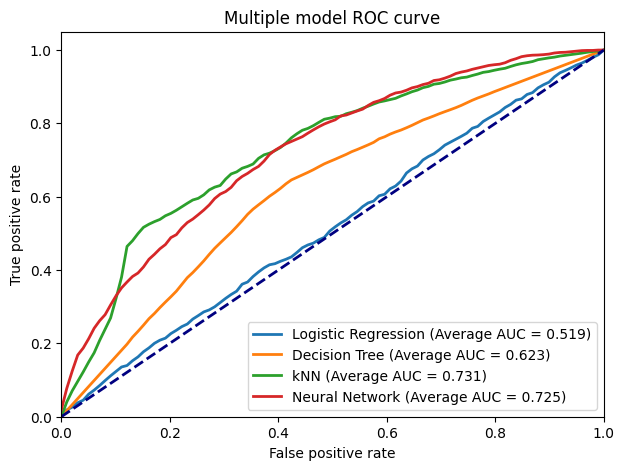

In [ ]:
# Create graphic
plt.figure(figsize=(7, 5))

# A curve for each model
for model in model_names:
    plt.plot(water_fpr_tpr[model][0], water_fpr_tpr[model][1], label=f'{model} (Average AUC = {water_auc[model]:.3f})', lw=2)

# Add labels
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Multiple model ROC curve')
plt.legend(loc="lower right")
plt.show()